In [1]:
from dgm_utils import train_model
from dgm_utils import show_samples, visualize_images, load_dataset
from dgm_utils import BaseModel

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional, Literal

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

if torch.cuda.is_available():
    DEVICE = "cuda"
    print('GPU found :)') 
else: 
    DEVICE = "cpu"
    print('GPU not found :(')

GPU found :)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:02<00:00, 3845592.08it/s]


Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 189189.39it/s]


Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 1829537.49it/s]


Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 4541246.43it/s]
C:\Users\twoli\AppData\Roaming\Python\Python310\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw



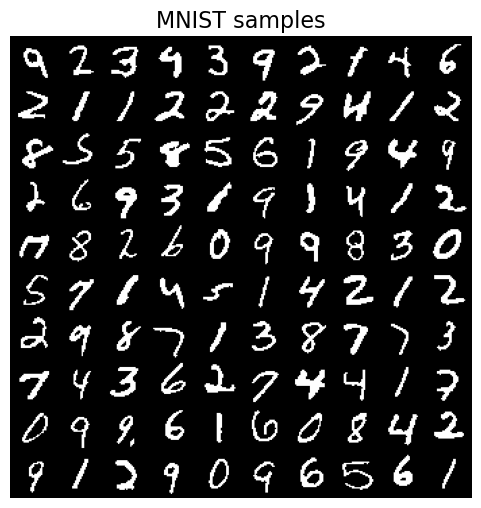

In [3]:
train_data, test_data = load_dataset("mnist", flatten=False, binarize=True)
visualize_images(train_data.astype(float), "MNIST samples")

In [4]:
class MaskedConv2d(nn.Conv2d):
    def __init__(
        self, mask_type: Literal['A', 'B'], in_channels: int, out_channels: int, kernel_size: int = 5
    ) -> None:
        assert mask_type in ["A", "B"]
        super().__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
        )
        # register_buffer() registers the tensor as a non-trainable buffer:
        # 1. It stays on the same device as the model (moves with .to(device)).
        # 2. It is not updated during backpropagation (not a learnable parameter).
        self.register_buffer("mask", torch.zeros_like(self.weight))
        self.create_mask(mask_type)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return F.conv2d(input, self.weight * self.mask, self.bias, padding=self.padding)

    def create_mask(self, mask_type: Literal['A', 'B']) -> None:
        # NOTE: try to understand the logic about mask_type
        k = self.kernel_size[0]
        self.mask[:, :, : k // 2] = 1
        self.mask[:, :, k // 2, : k // 2] = 1
        if mask_type == "B":
            self.mask[:, :, k // 2, k // 2] = 1

In [5]:
class LayerNorm(nn.LayerNorm):
    def __init__(self, n_filters: int) -> None:
        super().__init__(n_filters)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 2, 3, 1).contiguous()
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()

In [6]:
class PixelCNN(BaseModel):
    def __init__(
        self,
        input_shape: tuple[int, int],
        n_filters: int = 64,
        kernel_size: int = 7,
        n_layers: int = 5,
        use_layer_norm: bool = True,
    ) -> None:

        super().__init__()
        self.input_shape = input_shape

        # we apply the sequence of MaskedConv2d -> LayerNorm (it is optional) -> ReLU
        # the last layer should be MaskedConv2d (not ReLU)
        # Note 1: the first conv layer should be of type 'A'
        # Note 2: final output_dim in MaskedConv2d must be 2
        model: list[nn.Module] = [MaskedConv2d("A", 1, n_filters, kernel_size=kernel_size)]

        for _ in range(n_layers):
            if use_layer_norm:
                model.append(LayerNorm(n_filters))
            model.append(nn.ReLU())
            model.append(MaskedConv2d("B", n_filters, n_filters, kernel_size=kernel_size))

        model.append(nn.ReLU())
        model.append(MaskedConv2d("B", in_channels=n_filters, out_channels=2, kernel_size=1))
        self.net = nn.Sequential(*model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.shape[0]
        out = (x.float() - 0.5) / 0.5
        out = self.net(out)
        return out.view(batch_size, 2, 1, *self.input_shape)

    def loss(self, x: torch.Tensor) -> dict:
        # our loss is just cross entropy
        total_loss = F.cross_entropy(self(x), x.long())
        return {"total_loss": total_loss}

    @torch.no_grad()
    def sample(self, n: int) -> np.ndarray:
        # read carefully the sampling process
        # here you see the sequential process of sampling
        samples = torch.zeros(n, 1, *self.input_shape).to(self.device)
        for r in range(self.input_shape[0]):
            for c in range(self.input_shape[1]):
                logits = self(samples)[:, :, :, r, c]
                probs = F.softmax(logits, dim=1).squeeze(-1)
                samples[:, 0, r, c] = torch.multinomial(probs, num_samples=1).squeeze(-1)
        return samples.cpu().numpy()

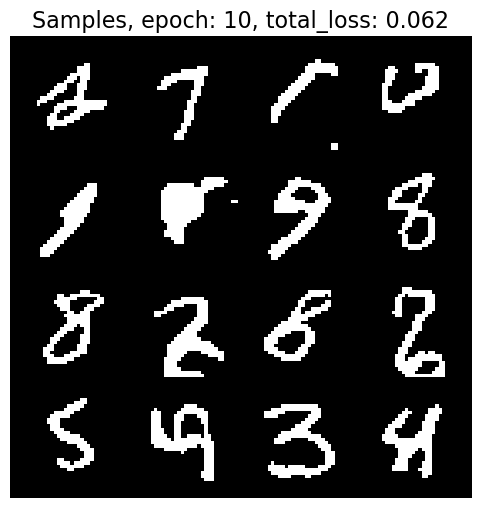

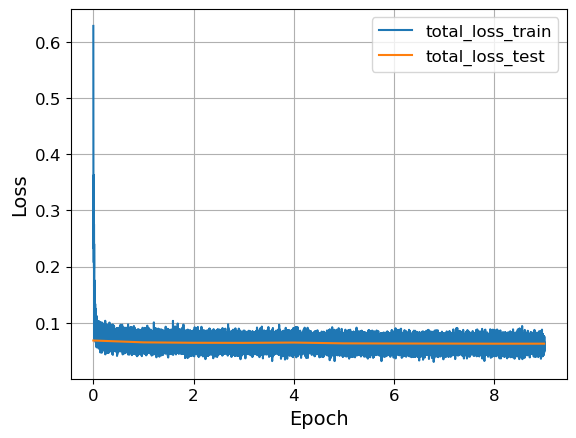

End of the training


In [7]:
# ====
# your code
# choose these parameters
EPOCHS = 10
BATCH_SIZE = 5
LR = 1e-4
N_LAYERS = 5
N_FILTERS = 64
USE_LAYER_NORM = True
# ====

pixel_cnn = PixelCNN(
    input_shape=(32, 32),
    n_filters=N_FILTERS,
    kernel_size=7,
    n_layers=N_LAYERS,
    use_layer_norm=USE_LAYER_NORM,
)

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

# choose any optimizer/scheduler as you want
optimizer = torch.optim.Adam(pixel_cnn.parameters(), lr=LR)

train_model(
    pixel_cnn,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    device=DEVICE,
    n_samples=16, # Remember the infernce is slow, so, you can lower the value 
    visualize_samples=True # or you can turn off smapling by setting `visualize_samples=False`
)

In [13]:
class PixelCNNAutoComplete(PixelCNN):
    @torch.no_grad()
    def sample(self, n: int, init: Optional[torch.Tensor] = None) -> np.ndarray:
        # ====
        # your code
        # this method almost the same as the method of the base PixelCNN model
        # but now if init is given, this tensor will be used as a starting image.
        # NOTE: fill the pixels only with value equals to -1 in the input tensor.

        # read carefully the sampling process
        # here you see the sequential process of sampling
        samples = torch.zeros(n, 1, *self.input_shape).to(self.device)
        if init is not None:
            samples = init.to(self.device)
        for r in range(self.input_shape[0]):
            for c in range(self.input_shape[1]):
                logits = self(samples)[:, :, :, r, c]
                probs = F.softmax(logits, dim=1).squeeze(-1)
                samples[:, 0, r, c] = torch.multinomial(probs, num_samples=1).squeeze(-1)
        return samples.cpu().numpy()

In [ ]:
pixel_cnn_ac = PixelCNNAutoComplete(
    input_shape=(32, 32),
    n_filters=N_FILTERS,
    kernel_size=7,
    n_layers=N_LAYERS,
    use_layer_norm=USE_LAYER_NORM,
)

pixel_cnn_ac.load_state_dict(pixel_cnn.state_dict())

<All keys matched successfully>

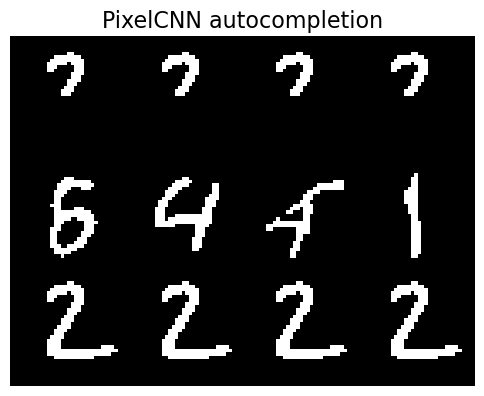

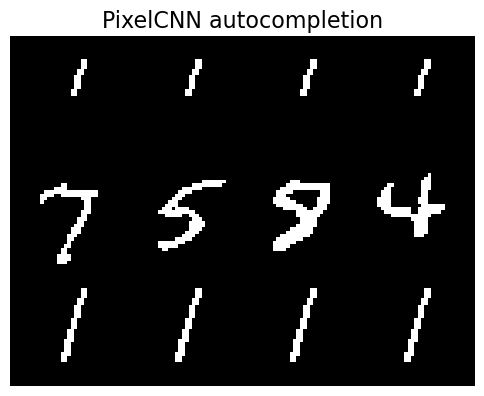

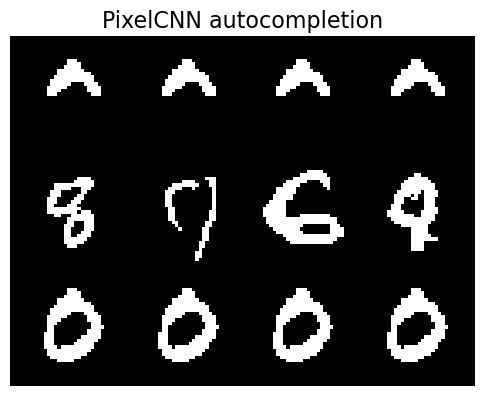

In [15]:
def autocomplete_image(
    original_image: np.ndarray, 
    model: PixelCNNAutoComplete, 
    n_samples: int
) -> None:
    # Remove lower half of the image
    original_image = np.repeat(original_image[None, :, :, :], n_samples, axis=0)
    masked_image = original_image.copy()
    masked_image[:, :, masked_image.shape[2] // 2 :, :] = -1
    
    # Generate completions
    generated_image = model.sample(n_samples, torch.tensor(masked_image).to(model.device))  
    images_to_show = np.concatenate([np.maximum(masked_image, 0), generated_image, original_image], axis=0)
    show_samples(images_to_show.astype(float), title="PixelCNN autocompletion", nrow=n_samples)

for i in range(1, 4):
    autocomplete_image(test_data[i], pixel_cnn_ac, n_samples=4)

In [ ]:
def plot_receptive_field(model: nn.Module, model_name: str) -> None:
    # ====
    # your code
    # 1) create tensor with zeros and set required_grad to True.
    input_tensor = torch.zeros(1, 32, 32, requires_grad=True)
    # 2) apply model to the tensor
    output = model(input_tensor)
    # 3) apply backward() to the center pixel of model output
    output_shape = output.shape[2:]
    x_center = output_shape[0] // 2
    y_center = output_shape[1] // 2
    target_pixel = torch.zeros_like(output)
    target_pixel[0, :, x_center, y_center] = 1
    output.backward(target_pixel)
    # 4) take the gradient with respect to input
    input_gradient = input_tensor.grad
    # 5) binary receptive field is an indicator map in which we stay 1's if absolute gradient more than 1e-8
    binary_map = (input_gradient.abs() > 1e-8).float()
    # 6) weighted receptive field is the normalized absolute gradient (values lies in [0, 1])
    weighted_map = input_gradient.abs() / input_gradient.abs().max()
    # ====

    # we stack the maps to get RGB image
    binary_map = np.stack([binary_map, binary_map, binary_map], axis=-1)
    weighted_map = np.stack([weighted_map, weighted_map, weighted_map], axis=-1)

    # center point will be red
    binary_map[x_center, y_center] = [1, 0, 0]
    weighted_map[x_center, y_center] = [1, 0, 0]

    fig, ax = plt.subplots(1, 2, figsize=(10, 6))
    ax[0].imshow(weighted_map, vmin=0.0, vmax=1.0)
    ax[1].imshow(binary_map, vmin=0.0, vmax=1.0)

    ax[0].set_title(f"Weighted receptive field for {model_name}")
    ax[1].set_title(f"Binary receptive field for {model_name}")

    ax[0].axis("off")
    ax[1].axis("off")
    plt.show()

In [34]:
for n_layers in [1, 3, 5, 6, 7]:
    model = PixelCNN(
        input_shape=(32, 32),
        n_filters=32,
        kernel_size=5,
        n_layers=n_layers,
        use_layer_norm=True
    )
    model = model.to(DEVICE)
    plot_receptive_field(model, model_name=f"PixelCNN {n_layers} layers")

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor